In [1]:
import os, pickle, json, random, csv, cv2
import numpy as np
import sys, getopt
from keras.layers.core import Lambda
from keras.callbacks import Callback
from keras.utils import np_utils
from keras.models import model_from_json
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Dropout, Flatten, Dense, ELU
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Cropping2D
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

BASE_IMAGE_DATA_PATH = '../data/IMG/'
BASE_DATA_FILE_PATH = '../data/driving_log.csv'

def load_data():
    samples = []
    with open(BASE_DATA_FILE_PATH) as csvfile:
        reader = csv.reader(csvfile)
        next(reader, None)
        for line in reader:
            #center_name = BASE_IMAGE_DATA_PATH + line[0].split('/')[-1]
            #center_image = cv2.imread(center_name) 
            #print("IMAGE SIZE =", center_image.shape) 
            samples.append(line)   

    return train_test_split(samples, test_size=0.01)



Using TensorFlow backend.


In [2]:
# Data augmentation constants
TRANS_X_RANGE = 100  # Number of translation pixels up to in the X direction for augmented data (-RANGE/2, RANGE/2)
TRANS_Y_RANGE = 10  # Number of translation pixels up to in the Y direction for augmented data (-RANGE/2, RANGE/2)
TRANS_ANGLE = .3  # Maximum angle change when translating in the X direction

BRIGHTNESS_RANGE = .25  # The range of brightness changes
ANGLE_THRESHOLD = 1.  # The maximum magitude of the angle possible

def img_trim(img):
    roi = img[60:130, :, :]
    return roi
    
def pre_process_image(img):
    IMG_ROWS = 64
    IMG_COLS = 64
    IMG_CH = 3
    
    # Remove the unwanted top scene and retain only the track
    #roi = img[60:130, :, :]
    # Resize the image
    resize = cv2.resize(img, (IMG_ROWS, IMG_COLS), interpolation=cv2.INTER_AREA)
    # Return the image sized as a 4D array
    #return np.resize(resize, (1, IMG_ROWS, IMG_COLS, IMG_CH))
    return resize

def img_translate(img, angle, x_range=TRANS_X_RANGE, y_range=TRANS_Y_RANGE):
    # Compute X translation
    x_translation = (x_range * np.random.uniform()) - (x_range / 2)
    new_angle = angle + ((x_translation / x_range) * 2) * TRANS_ANGLE
    # Randomly compute a Y translation
    y_translation = (y_range * np.random.uniform()) - (y_range / 2)
    # Form the translation matrix
    translation_matrix = np.float32([[1, 0, x_translation], [0, 1, y_translation]])
    # Translate the image
    image_tr = cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0]))
    return image_tr,new_angle

def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform() - trans_range/2
    steer_ang = steer + ((tr_x/trans_range) *2 ) * TRANS_ANGLE
    
    # To Simulate Driving up and down the road
    tr_y = 40*np.random.uniform()-40/2
    #tr_y = 0
    
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(image.shape[1], image.shape[0]))
    
    return image_tr,steer_ang

def img_change_brightness(img):
    # Convert the image to HSV
    temp = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Compute a random brightness value and apply to the image
    brightness = BRIGHTNESS_RANGE + np.random.uniform()
    temp[:, :, 2] = temp[:, :, 2] * brightness

    # Convert back to RGB and return
    return cv2.cvtColor(temp, cv2.COLOR_HSV2RGB)

Image Path= ../data/IMG/center_2016_12_01_13_36_04_425.jpg 
Angle =  -0.04076847


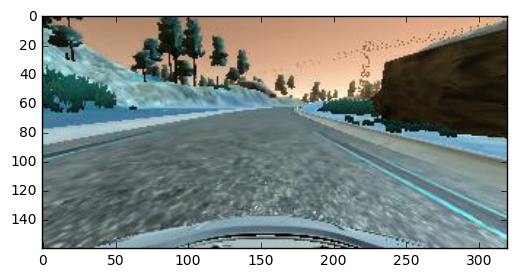

In [3]:
#Visualization of DATA

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

demo_t_samples, demo_v_samples = load_data();
demo_first_sample = demo_t_samples[0]
demo_center_name = BASE_IMAGE_DATA_PATH + demo_first_sample[0].split('/')[-1]

#pil_im = Image.open(demo_center_name, 'r')
#imshow(np.asarray(pil_im))

#demo_center_image = pre_process_image(cv2.imread(demo_center_name))
demo_center_image = cv2.imread(demo_center_name)
demo_center_angle = float(demo_first_sample[3])
print("Image Path=", demo_center_name, "\nAngle = ", demo_center_angle)
#cv2.imshow('image', demo_center_image)
imshow(demo_center_image)


Angle =  -0.04076847


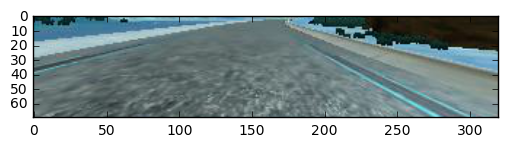

In [4]:
demo_center_image = img_trim(demo_center_image)
            
print("Angle = ", demo_center_angle)
imshow(demo_center_image)

Angle =  -0.04076847


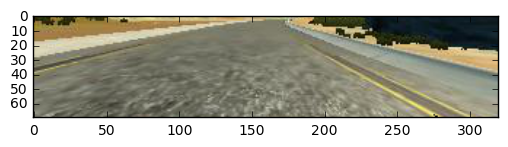

In [5]:
demo_center_image = img_change_brightness(demo_center_image)  # Randomly change the brightness
            
print("Angle = ", demo_center_angle)
imshow(demo_center_image)

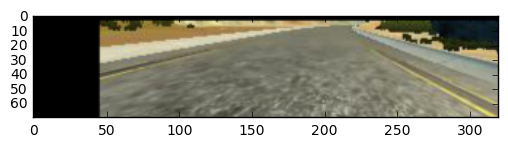

In [6]:
#Translating the image 
demo_center_image, demo_center_angle = img_translate(demo_center_image, demo_center_angle)
imshow(demo_center_image)

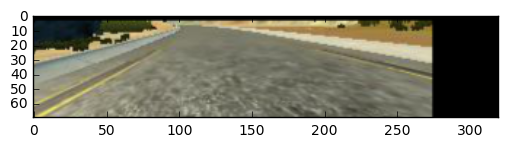

In [7]:
demo_center_image = cv2.flip(demo_center_image,1)
img_angle = float(demo_center_angle)*-1.0
imshow(demo_center_image)

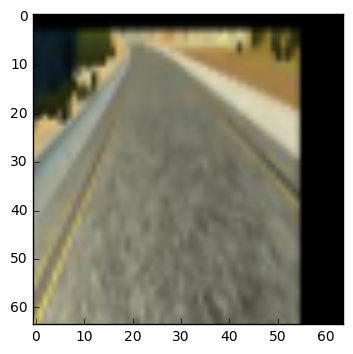

In [8]:
demo_center_image = pre_process_image(demo_center_image)
imshow(demo_center_image)

In [9]:
def prepare_features(batch_samples):

    images = []
    angles = []

    allowedZEROAngle = len(batch_samples)/10
    countZeroAngle= 0
    skippingFeatures = 0

    bias = 0.4
    for batch_sample in batch_samples:

        # Define a random threshold for each image taken
        threshold = np.random.uniform()
        correction_factor = (np.random.uniform(0, 1) * 0.3) + 0.1

        if (batch_sample[1].strip() in (None, "")) or (batch_sample[2].strip() in (None, "")):
            img_choice = 0
        else:
            img_choice = np.random.randint(3)

        img_path = BASE_IMAGE_DATA_PATH + batch_sample[img_choice].split('/')[-1]
        center_angle = float(batch_sample[3])

        if center_angle == 0: 
            if countZeroAngle > allowedZEROAngle:
                skippingFeatures +=1
                continue
            else:
                countZeroAngle +=1
                #print("currentZeroAngle=", countZeroAngle, " and allowedZEROAngle=", allowedZEROAngle)

        if img_choice == 0:
            img_angle = center_angle
        elif img_choice == 1:
            img_angle = center_angle + correction_factor
        else:
            img_angle = center_angle - correction_factor


        chosen_image = cv2.imread(img_path)
        chosen_image = img_trim(chosen_image) # Select only region of interest
        chosen_image = img_change_brightness(chosen_image)  # Randomly change the brightness

        #Translating the image 
        chosen_image, img_angle = img_translate(chosen_image, img_angle)

        if (abs(img_angle) + bias) >= threshold and abs(img_angle) <= 1.:
            flipping_choice = np.random.randint(2)
            if flipping_choice == 1:
                chosen_image = cv2.flip(chosen_image,1)
                img_angle = float(img_angle)*-1.0

            chosen_image = pre_process_image(chosen_image)
            images.append(chosen_image)
            angles.append(img_angle)

    #print("Skipping Features = ", skippingFeatures)  

    # trim image to only see section with road
    #X_train = X_train[:,80:,:,:] 
    X_train = np.array(images, dtype=np.float64)
    y_train = np.array(angles, dtype=np.float64)
    return X_train, y_train

Features Prepared =  2960 , 2960
[ 0.49748172  0.06361554  0.11647291 ..., -0.46357606  0.58536302
  0.55954252]


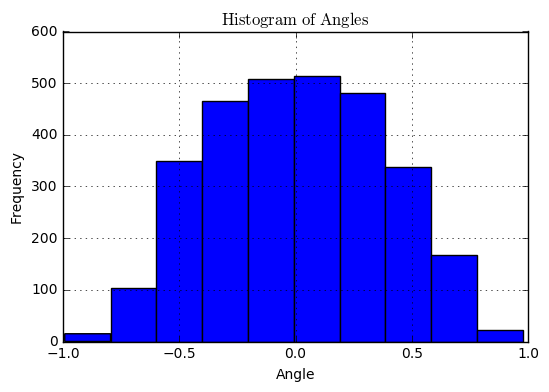

In [10]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

def plot_features():
    train_samples, validation_samples = load_data()
    X_train, y_train = prepare_features(train_samples)
    print("Features Prepared = ", len(X_train) , ",", len(y_train))
    
    print(y_train)
    # the histogram of the data
    n, bins, patches = plt.hist(y_train)

    # add a 'best fit' line
    #y = mlab.normpdf( bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=1)

    plt.xlabel('Angle')
    plt.ylabel('Frequency')
    plt.title(r'$\mathrm{Histogram\ of\ Angles}$')
    #plt.axis([-2000, 2000, 0, 6000])
    plt.grid(True)
    plt.show()
    
plot_features()

train_samples= 7955 validation_samples= 81
Features Prepared =  2918 , 2918
[-0.16599493  0.50550632 -0.24631279 ...,  0.75564755 -0.84707459
  0.45451066]


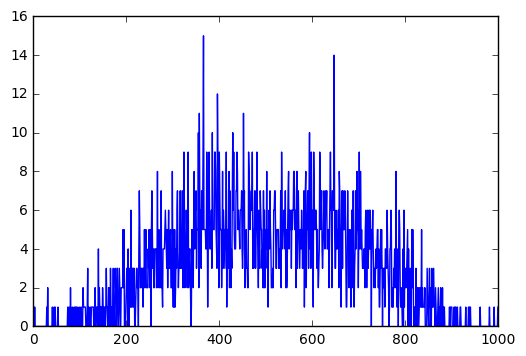

In [11]:
def plot_detail_features():
    train_samples, validation_samples = load_data()
    print("train_samples=", len(train_samples), "validation_samples=", len(validation_samples))
    X_train, y_train = prepare_features(train_samples)
    print("Features Prepared = ", len(X_train) , ",", len(y_train))  
    print(y_train)
    hist, bin_edges = np.histogram(y_train, bins=1000)
    #print(hist)
    plt.plot(hist)
    
plot_detail_features() 


In [12]:
def generator(samples, batch_size=128):
    a=0
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        #print("####### No of samples=", num_samples)
        for offset in range(0, num_samples, batch_size):

            #print("####### CALLING NEXT TIME WITH OFFSET=", offset)
            batch_samples = samples[offset:offset+batch_size]
            X_train, y_train = prepare_features(batch_samples)
            #print("Features Trained = ", len(X_train) , ",", len(y_train))
            yield sklearn.utils.shuffle(X_train, y_train)

In [13]:
def getModel():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(64,64,3), output_shape=(64,64,3)))

    # Also, region of interest function can be applied.
    # trim the hood of the car
    #model.add(Lambda(lambda x: x[:,35:-10,:,:]))
    #model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3)))
    
    model.add(Convolution2D(32, 3, 3, subsample=(1, 1), border_mode="same"))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same"))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))
    model.add(Convolution2D(128, 3, 3, subsample=(1, 1), border_mode="same"))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dropout(.5))
    model.add(Dense(128))
    model.add(Dropout(.5))
    model.add(Dense(64))
    model.add(Dropout(.5))
    model.add(Dense(1))

    adam = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=adam)

    return model 

In [14]:
def main(modelType):
    
    print('Model name passed in param is', modelType)
    train_samples, validation_samples = load_data() 
    print("X_train count=", len(train_samples), "X_val count=", len(validation_samples))
        
    # compile and train the model using the generator function
    train_generator = generator(train_samples, batch_size=32)
    validation_generator = generator(validation_samples, batch_size=32)

    if modelType=='DEFAULT':
        model = getModel()
    """elif modelType=='LENET':
    #    model = getLenetModel()
    elif modelType=='UD-LIVE-DEMOMODEL':
        model = getUdacityLiveDemoModel()
    elif modelType=="NODROPOUT":
        model = getModelNoDropout()"""
        
    outputDir = "./output/" + modelType + "/"
    
    if not os.path.exists(outputDir):
        os.makedirs(outputDir)
    
    filepath = outputDir + "model-{epoch:02d}-{val_loss:.4f}.h5"
    checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=False, save_weights_only=False)  
    print("Saving model.")
    with open(outputDir + 'model.json', 'w') as outfile:
       json.dump(model.to_json(), outfile)

    model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*2, validation_data=validation_generator, 
            nb_val_samples=len(validation_samples), nb_epoch=10, callbacks=[checkpoint])

    print("Saving weights.")
    model.save_weights(outputDir + 'model_weights.h5')
    
    print("Model Saved at location = {}".format(outputDir))

In [15]:
main('DEFAULT')

Model name passed in param is DEFAULT
X_train count= 7955 X_val count= 81
Saving model.
Epoch 1/10
15902/15910 [============================>.] - ETA: 0s - loss: 0.0629

/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: saving model to ./output/DEFAULT/model-00-0.0426.h5
15915/15910 [==============================] - 134s - loss: 0.0629 - val_loss: 0.0426
Epoch 2/10
15918/15910 [==============================] - 130s - loss: 0.0505 - val_loss: 0.0528
Epoch 3/10
15920/15910 [==============================] - 132s - loss: 0.0476 - val_loss: 0.0415
Epoch 4/10
15916/15910 [==============================] - 130s - loss: 0.0461 - val_loss: 0.0345
Epoch 5/10
15919/15910 [==============================] - 131s - loss: 0.0450 - val_loss: 0.0366
Epoch 6/10
15924/15910 [==============================] - 133s - loss: 0.0437 - val_loss: 0.0374
Epoch 7/10
15913/15910 [==============================] - 132s - loss: 0.0433 - val_loss: 0.0404
Epoch 8/10
15910/15910 [==============================] - 129s - loss: 0.0426 - val_loss: 0.0330
Epoch 9/10
15918/15910 [==============================] - 130s - loss: 0.0408 - val_loss: 0.0442
Epoch 10/10
15910/15910 [==============================] - 131s - loss: 0